<a href="https://colab.research.google.com/github/shayleaschreurs/Project-2/blob/main/Final_ML_Trading_Bot_with_Figs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Trading Bot

## Background
- Three machine learning models were utilized to train and predict the trading data sourced from Alpaca API. 
- The target was determined to be the entry price plus 3 times the Average True Range(ATR): '1'.
- The stop was determined to be the entry price minus the Average True Range (ATR): '-1'. 
- Support Vector Machine (SVM), Decision Tree models, and Stochasstic Gradient Descent (SGD) were applied to this data.

In [9]:
!pip install finta
!pip install hvplot
!pip install alpaca_trade_api
# initial imports
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt 
from finta import TA

import pandas as pd 
import hvplot.pandas
from pandas.tseries.offsets import DateOffset

import alpaca_trade_api as tradeapi

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

import pydotplus
from IPython.display import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Download stock time-series data from Alpaca API into Pandas DataFrame

In [10]:
# API credentials
ALPACA_API_KEY = 'PKETI0Q5C8PPUXVNHJFJ'
ALPACA_SECRET_KEY = 'WQxmEpBCoMXydCCg0G8cUe6hGLpgaAfrvedZ09Fy'
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"

# Create a connection to the API 
api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPACA_API_BASE_URL, api_version="v2")

# Set signal variable
signal = 1

# Create buy signal, num shares and ticker
if signal == 1:
    orderSide = "buy"
else:
    orderSide = "sell"
    
# Set the ticket symbol and the number of shares to buy
ticker = "AAPL"
number_of_shares = 1

# Make API call
signals_df = api.get_bars(ticker, "5Min", "2022-01-01", "2022-10-25", adjustment='raw').df

# create a seperate dataframe for signals
signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-01-03 09:00:00+00:00,178.26,178.34,178.1500,178.15,6894,235,178.243947
2022-01-03 09:05:00+00:00,178.20,178.20,177.7600,177.99,4767,186,177.958045
2022-01-03 09:10:00+00:00,177.91,178.08,177.9000,178.08,3598,120,177.952941
2022-01-03 09:15:00+00:00,178.08,178.12,177.8100,177.86,8398,207,177.998975
2022-01-03 09:20:00+00:00,178.02,178.02,178.0000,178.00,1369,72,178.007063
...,...,...,...,...,...,...,...
2022-10-25 23:35:00+00:00,150.46,150.55,150.4600,150.52,9451,96,150.512152
2022-10-25 23:40:00+00:00,150.53,150.60,150.5200,150.57,7411,141,150.559257
2022-10-25 23:45:00+00:00,150.56,150.70,150.5501,150.60,10287,88,150.592303


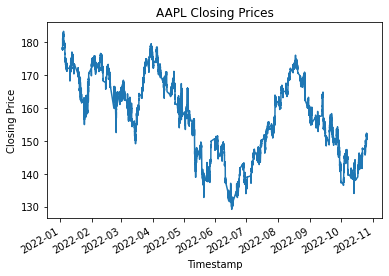

In [11]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

### Add Features (Techincal Analysis Indicators) to the DataFrame

In [12]:
#  Setup EMAs for crosses
longest_MA_window = 200
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, longest_MA_window)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns="SIGNAL", inplace=True)

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD
timestamp,,,,,,,,,,,,,,,,,
2022-01-03 09:00:00+00:00,178.26,178.34,178.1500,178.15,6894,235,178.243947,178.150000,178.150000,178.150000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2022-01-03 09:05:00+00:00,178.20,178.20,177.7600,177.99,4767,186,177.958045,178.061111,178.066000,178.068400,NaN,NaN,0.000000,NaN,NaN,NaN,-0.003590
2022-01-03 09:10:00+00:00,177.91,178.08,177.9000,178.08,3598,120,177.952941,178.068852,178.071141,178.072422,NaN,NaN,37.724551,NaN,NaN,NaN,-0.001783
2022-01-03 09:15:00+00:00,178.08,178.12,177.8100,177.86,8398,207,177.998975,177.998103,178.010188,178.016089,NaN,NaN,18.927664,NaN,NaN,NaN,-0.008861
2022-01-03 09:20:00+00:00,178.02,178.02,178.0000,178.00,1369,72,178.007063,177.998667,178.007723,178.012609,NaN,NaN,39.564532,NaN,NaN,NaN,-0.006949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25 23:35:00+00:00,150.46,150.55,150.4600,150.52,9451,96,150.512152,150.580911,150.694473,150.931978,150.535074,0.192857,41.573799,151.212761,150.7660,150.319239,-0.135713
2022-10-25 23:40:00+00:00,150.53,150.60,150.5200,150.57,7411,141,150.559257,150.578729,150.682619,150.917782,150.539824,0.174286,43.550684,151.139286,150.7345,150.329714,-0.129294
2022-10-25 23:45:00+00:00,150.56,150.70,150.5501,150.60,10287,88,150.592303,150.582983,150.674750,150.905320,150.544574,0.162136,44.758430,151.131426,150.7240,150.316574,-0.120398


### Add Discrete Features Columns to the DataFrame

In [13]:
# discrete or continuous features (techinal indicators) may be used
continuous_features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_LOWER", "MACD"]
discrete_features = ["Bollinger_Bands_Above_Upper_BB", "Bollinger_Bands_Below_Lower_BB", "9EMA/20EMA_Cross, 9EMA>20EMA", "9EMA/20EMA_Cross, 9EMA<20EMA", "50EMA/200SMA_Cross, 50EMA>200SMA", "50EMA/200SMA_Cross, 50EMA<200SMA", "RSI_Over_70", "RSI_Under_30", "VWAP_Cross_From_Above", "VWAP_Cross_From_Below"]
all_features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_MIDDLE", "BB_LOWER", "MACD", "Bollinger_Bands_Above_Upper_BB", "Bollinger_Bands_Below_Lower_BB", "9EMA/20EMA_Cross, 9EMA>20EMA", "9EMA/20EMA_Cross, 9EMA<20EMA", "50EMA/200SMA_Cross, 50EMA>200SMA", "50EMA/200SMA_Cross, 50EMA<200SMA", "RSI_Over_70", "RSI_Under_30", "VWAP_Cross_From_Above", "VWAP_Cross_From_Below"]

# add discrete_features to the DataFrame
for feature in discrete_features:
    signals_df[feature] = 0.0

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,Bollinger_Bands_Above_Upper_BB,Bollinger_Bands_Below_Lower_BB,"9EMA/20EMA_Cross, 9EMA>20EMA","9EMA/20EMA_Cross, 9EMA<20EMA","50EMA/200SMA_Cross, 50EMA>200SMA","50EMA/200SMA_Cross, 50EMA<200SMA",RSI_Over_70,RSI_Under_30,VWAP_Cross_From_Above,VWAP_Cross_From_Below
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:00:00+00:00,178.26,178.34,178.1500,178.15,6894,235,178.243947,178.150000,178.150000,178.150000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-03 09:05:00+00:00,178.20,178.20,177.7600,177.99,4767,186,177.958045,178.061111,178.066000,178.068400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-03 09:10:00+00:00,177.91,178.08,177.9000,178.08,3598,120,177.952941,178.068852,178.071141,178.072422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-03 09:15:00+00:00,178.08,178.12,177.8100,177.86,8398,207,177.998975,177.998103,178.010188,178.016089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-03 09:20:00+00:00,178.02,178.02,178.0000,178.00,1369,72,178.007063,177.998667,178.007723,178.012609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25 23:35:00+00:00,150.46,150.55,150.4600,150.52,9451,96,150.512152,150.580911,150.694473,150.931978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-25 23:40:00+00:00,150.53,150.60,150.5200,150.57,7411,141,150.559257,150.578729,150.682619,150.917782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-25 23:45:00+00:00,150.56,150.70,150.5501,150.60,10287,88,150.592303,150.582983,150.674750,150.905320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Encode Discrete Features (EMA Crosses, SMA Crosses, etc...)

In [14]:
# Generate the trading signals 1  for a long position trading algorithm
# where 1 is when the Close price is less than the BB_LOWER window
# where 1 is when the Close price is greater the the BB_UPPER window
for index, row in signals_df.iterrows():
    if row["close"] < row["BB_LOWER"]:
        signals_df.loc[index, "Bollinger_Bands_Below_Lower_BB"] = 1
    if row["close"] > row["BB_UPPER"]:
        signals_df.loc[index,"Bollinger_Bands_Above_Upper_BB"] = 1

# Generate the trading signal 1 or 0
# where 1 is when the Short window is greater than (or crosses over) the Long Window
# where 0 is when the Short window is under the Long window
signals_df["9EMA/20EMA_Cross, 9EMA>20EMA"][9:] = np.where(
    signals_df["9EMA"][9:] > signals_df["20EMA"][9:], 1.0, 0.0)
# Calculate the points in time at which a position should be taken, 1 or 1, when there is ANY cross
# we will get rid of -1s at the end
signals_df["9EMA/20EMA_Cross, 9EMA>20EMA"] = signals_df["9EMA/20EMA_Cross, 9EMA>20EMA"].diff()
signals_df["9EMA/20EMA_Cross, 9EMA<20EMA"] = (signals_df["9EMA/20EMA_Cross, 9EMA>20EMA"]) * -1

# Generate the trading signal 1 or 0
# where 1 is when the Short window is greater than (or crosses over) the Long Window
# where 0 is when the Short window is under the Long window
signals_df["50EMA/200SMA_Cross, 50EMA>200SMA"][50:] = np.where(
    signals_df["50EMA"][50:] > signals_df["200SMA"][50:], 1.0, 0.0)
# Calculate the points in time at which a position should be taken, 1 or 1, when there is ANY cross
# we will get rid of -1s at the end
signals_df["50EMA/200SMA_Cross, 50EMA>200SMA"] = signals_df["50EMA/200SMA_Cross, 50EMA>200SMA"].diff()
signals_df["50EMA/200SMA_Cross, 50EMA<200SMA"] = (signals_df["50EMA/200SMA_Cross, 50EMA>200SMA"]) * -1

# Generate the trading signals 1 (entry) for a long position trading algorithm
# where 1 is when the RSI is below 30
# where 1 is when the RSI is above 70
for index, row in signals_df.iterrows():
    if 30 > row["RSI"]:
        signals_df.loc[index, "RSI_Under_30"] = 1
    if 70 < row["RSI"]:
        signals_df.loc[index,"RSI_Over_70"] = 1

# Generate the trading signal 1 or 0,
# where 1 is when the price is above VWAP
# where 0 is when the price is below VWAP
signals_df["VWAP_Cross_From_Above"] = np.where(
    signals_df["vwap"] <= signals_df["close"], 1.0, 0)
# Calculate the points in time at which a position should be taken, 1, when price crosses VWAP
# we will get rid of -1s at the end
signals_df["VWAP_Cross_From_Above"] = signals_df["VWAP_Cross_From_Above"].diff()
signals_df["VWAP_Cross_From_Below"] = (signals_df["VWAP_Cross_From_Above"]) * -1

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Exit Price"] = 0
signals_df["Exit"] = 0

# Review DataFrame
signals_df.head(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,"9EMA/20EMA_Cross, 9EMA>20EMA","9EMA/20EMA_Cross, 9EMA<20EMA","50EMA/200SMA_Cross, 50EMA>200SMA","50EMA/200SMA_Cross, 50EMA<200SMA",RSI_Over_70,RSI_Under_30,VWAP_Cross_From_Above,VWAP_Cross_From_Below,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:00:00+00:00,178.2600,178.3400,178.1500,178.1500,6894,235,178.243947,178.150000,178.150000,178.150000,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,0
2022-01-03 09:05:00+00:00,178.2000,178.2000,177.7600,177.9900,4767,186,177.958045,178.061111,178.066000,178.068400,...,0.0,-0.0,0.0,-0.0,0.0,1.0,1.0,-1.0,0,0
2022-01-03 09:10:00+00:00,177.9100,178.0800,177.9000,178.0800,3598,120,177.952941,178.068852,178.071141,178.072422,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0,0
2022-01-03 09:15:00+00:00,178.0800,178.1200,177.8100,177.8600,8398,207,177.998975,177.998103,178.010188,178.016089,...,0.0,-0.0,0.0,-0.0,0.0,1.0,-1.0,1.0,0,0
2022-01-03 09:20:00+00:00,178.0200,178.0200,178.0000,178.0000,1369,72,178.007063,177.998667,178.007723,178.012609,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03 16:55:00+00:00,181.6400,181.6900,181.3500,181.4800,578836,6242,181.527858,181.401474,181.055327,180.209134,...,0.0,-0.0,0.0,-0.0,0.0,0.0,-1.0,1.0,0,0
2022-01-03 17:00:00+00:00,181.4700,181.5200,181.2544,181.4550,653886,6438,181.370594,181.412179,181.093394,180.259022,...,0.0,-0.0,0.0,-0.0,0.0,0.0,1.0,-1.0,0,0
2022-01-03 17:05:00+00:00,181.4590,181.4893,181.2100,181.3050,534341,5573,181.333179,181.390743,181.113548,180.300870,...,0.0,-0.0,0.0,-0.0,0.0,0.0,-1.0,1.0,0,0


### Create Volatility Based Targets and Stops

In [15]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
num_rows_in_df = signals_df.shape[0]

# reward:risk ratio
reward = 3
risk = 1

# we also figure out our exit price
# hitting target price before the stop price signals a win and will be 1
# hitting stop price before hitting the target price signals a loss and will be -1
# loop thru the dataframe, from the longest_MA_window to the end (num_rows_in_df) to avoid NaN values
for j in range(longest_MA_window, num_rows_in_df):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - (risk * atr)
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (reward * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, num_rows_in_df):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df["Exit Price"].iloc[j] = stop
            signals_df["Exit"].iloc[j] = -1
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df["Exit Price"].iloc[j] = target
            signals_df["Exit"].iloc[j] = 1
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[longest_MA_window:]

signals_df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,"9EMA/20EMA_Cross, 9EMA>20EMA","9EMA/20EMA_Cross, 9EMA<20EMA","50EMA/200SMA_Cross, 50EMA>200SMA","50EMA/200SMA_Cross, 50EMA<200SMA",RSI_Over_70,RSI_Under_30,VWAP_Cross_From_Above,VWAP_Cross_From_Below,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-04 09:40:00+00:00,182.61,182.87,182.6000,182.87,7550,183,182.697110,182.515386,182.316310,182.138213,...,0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,183.360693,1
2022-01-04 09:45:00+00:00,182.85,182.85,182.7200,182.75,1925,81,182.759138,182.562309,182.357614,182.162212,...,0.0,-0.0,0.0,-0.0,0.0,0.0,-1.0,1.0,183.253550,1
2022-01-04 09:50:00+00:00,182.80,182.81,182.7800,182.78,1970,73,182.794741,182.605847,182.397841,182.186446,...,0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,183.270714,1
2022-01-04 09:55:00+00:00,182.78,182.95,182.7800,182.87,3579,144,182.873537,182.658678,182.442808,182.213260,...,0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,183.365000,1
2022-01-04 10:00:00+00:00,182.89,182.96,182.8400,182.96,5728,114,182.877489,182.718942,182.492065,182.242552,...,0.0,-0.0,0.0,-0.0,1.0,0.0,1.0,-1.0,182.792857,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25 23:35:00+00:00,150.46,150.55,150.4600,150.52,9451,96,150.512152,150.580911,150.694473,150.931978,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.000000,0
2022-10-25 23:40:00+00:00,150.53,150.60,150.5200,150.57,7411,141,150.559257,150.578729,150.682619,150.917782,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.000000,0
2022-10-25 23:45:00+00:00,150.56,150.70,150.5501,150.60,10287,88,150.592303,150.582983,150.674750,150.905320,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.000000,0


### Data Cleaning

In [16]:
# check if there is potentially-unwanted zeros in the dataframe
# zeros come from the end of the dataframe where neither the target or stop were hit
signals_df["Exit"].value_counts()

-1    28787
 1    10275
 0       33
Name: Exit, dtype: int64

In [17]:
# remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]
signals_df["Exit"].value_counts()

-1    28787
 1    10275
Name: Exit, dtype: int64

In [18]:
# check for unwanted -0s and -1s
for i in discrete_features:
    print(signals_df[i].value_counts())

0.0    36849
1.0     2213
Name: Bollinger_Bands_Above_Upper_BB, dtype: int64
0.0    36947
1.0     2115
Name: Bollinger_Bands_Below_Lower_BB, dtype: int64
 0.0    37279
-1.0      892
 1.0      891
Name: 9EMA/20EMA_Cross, 9EMA>20EMA, dtype: int64
-0.0    37279
 1.0      892
-1.0      891
Name: 9EMA/20EMA_Cross, 9EMA<20EMA, dtype: int64
 0.0    38794
-1.0      134
 1.0      134
Name: 50EMA/200SMA_Cross, 50EMA>200SMA, dtype: int64
-0.0    38794
 1.0      134
-1.0      134
Name: 50EMA/200SMA_Cross, 50EMA<200SMA, dtype: int64
0.0    37217
1.0     1845
Name: RSI_Over_70, dtype: int64
0.0    37046
1.0     2016
Name: RSI_Under_30, dtype: int64
 0.0    19655
 1.0     9704
-1.0     9703
Name: VWAP_Cross_From_Above, dtype: int64
-0.0    19655
-1.0     9704
 1.0     9703
Name: VWAP_Cross_From_Below, dtype: int64


In [19]:
# remove all unwanted -0s and -1s which will affect ML model
for i in discrete_features:
    signals_df[i] = signals_df[i].replace(-0, 0)
    signals_df[i] = signals_df[i].replace(-1, 0)
    print(signals_df[i].value_counts())

0.0    36849
1.0     2213
Name: Bollinger_Bands_Above_Upper_BB, dtype: int64
0.0    36947
1.0     2115
Name: Bollinger_Bands_Below_Lower_BB, dtype: int64
0.0    38171
1.0      891
Name: 9EMA/20EMA_Cross, 9EMA>20EMA, dtype: int64
0.0    38170
1.0      892
Name: 9EMA/20EMA_Cross, 9EMA<20EMA, dtype: int64
0.0    38928
1.0      134
Name: 50EMA/200SMA_Cross, 50EMA>200SMA, dtype: int64
0.0    38928
1.0      134
Name: 50EMA/200SMA_Cross, 50EMA<200SMA, dtype: int64
0.0    37217
1.0     1845
Name: RSI_Over_70, dtype: int64
0.0    37046
1.0     2016
Name: RSI_Under_30, dtype: int64
0.0    29358
1.0     9704
Name: VWAP_Cross_From_Above, dtype: int64
0.0    29359
1.0     9703
Name: VWAP_Cross_From_Below, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Setup Train and Test Sets for Discrete and Continuous Features

In [20]:
# make sure we have a sufficient training period
training_begin = str(signals_df.index.min())
training_end = str(signals_df.index.min() + DateOffset(months=3))

training_begin, training_end

('2022-01-04 09:40:00+00:00', '2022-04-04 09:40:00+00:00')

In [21]:
# choose if you want continuous or discrete features
discrete_X = signals_df[discrete_features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
discrete_y = signals_df["Exit"]
discrete_X.head()

,Bollinger_Bands_Above_Upper_BB,Bollinger_Bands_Below_Lower_BB,"9EMA/20EMA_Cross, 9EMA>20EMA","9EMA/20EMA_Cross, 9EMA<20EMA","50EMA/200SMA_Cross, 50EMA>200SMA","50EMA/200SMA_Cross, 50EMA<200SMA",RSI_Over_70,RSI_Under_30,VWAP_Cross_From_Above,VWAP_Cross_From_Below
timestamp,,,,,,,,,,
2022-01-04 09:40:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-01-04 09:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-01-04 09:50:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-01-04 09:55:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-01-04 10:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Split the data into training and testing sets.

In [22]:
# Splitting into Train and Test sets
discrete_X_train = discrete_X.loc[training_begin: training_end]
discrete_y_train = discrete_y.loc[training_begin: training_end]

# Generate the discrete X_test and y_test DataFrames
discrete_X_test = discrete_X.loc[training_end:]
discrete_y_test = discrete_y.loc[training_end:]

# code above is used in liue of 
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [23]:
# we must balance out dataset
discrete_rus = RandomUnderSampler(random_state=1)
undersampled_discrete_X_train, undersampled_discrete_y_train = discrete_rus.fit_resample(discrete_X_train, discrete_y_train)

In [24]:
# choose if you want continuous or discrete features
continuous_X = signals_df[continuous_features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
continuous_y = signals_df["Exit"]
continuous_y.head()

timestamp
2022-01-04 09:40:00+00:00    1
2022-01-04 09:45:00+00:00    1
2022-01-04 09:50:00+00:00    1
2022-01-04 09:55:00+00:00    1
2022-01-04 10:00:00+00:00   -1
Name: Exit, dtype: int64

In [25]:
# Splitting into Train and Test sets
continuous_X_train = continuous_X.loc[training_begin: training_end]
continuous_y_train = continuous_y.loc[training_begin: training_end]

# Generate the continuous X_test and y_test DataFrames
continuous_X_test = continuous_X.loc[training_end:]
continuous_y_test = continuous_y.loc[training_end:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [26]:
# Scale the continuous data
scaler = StandardScaler()
X_scaler = scaler.fit(continuous_X_train)
continuous_X_train_scaled = X_scaler.transform(continuous_X_train)
continuous_X_test_scaled = X_scaler.transform(continuous_X_test)

In [27]:
# Undersample the continuous data
continuous_rus = RandomUnderSampler(random_state=1)
undersampled_continuous_X_train_scaled, undersampled_continuous_y_train = continuous_rus.fit_resample(continuous_X_train_scaled, continuous_y_train)

### Support Vector Machine (SVC) Model

In [28]:
# Create the classifier model
svm_model = svm.SVC(random_state=1)
 
# Fit the model to the data using undersampled_continuous_X_train_scaled and undersampled_continuous_y_train
svm_model = svm_model.fit(undersampled_continuous_X_train_scaled, undersampled_continuous_y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(undersampled_continuous_X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([ 1, -1, -1,  1, -1, -1, -1, -1, -1, -1])

In [29]:
# Evaluate the model using a classification report
svm_training_report = classification_report(undersampled_continuous_y_train, training_signal_predictions)
print(svm_training_report)

              precision    recall  f1-score   support

          -1       0.59      0.66      0.62      2960
           1       0.62      0.54      0.58      2960

    accuracy                           0.60      5920
   macro avg       0.60      0.60      0.60      5920
weighted avg       0.60      0.60      0.60      5920



In [30]:
# Use the trained model to predict the trading signals for the testing data.
svm_testing_signal_predictions = svm_model.predict(continuous_X_test_scaled)

In [31]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(continuous_y_test, svm_testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

          -1       0.76      0.25      0.38     19867
           1       0.28      0.78      0.41      7315

    accuracy                           0.40     27182
   macro avg       0.52      0.52      0.40     27182
weighted avg       0.63      0.40      0.39     27182



In [55]:
# Create a predictions DataFrame for SVM
svm_predictions_df = pd.DataFrame(index=continuous_X_test.index)

svm_predictions_df["predicted_signal"] = svm_testing_signal_predictions

svm_predictions_df["initial_investment"] = signals_df["close"].pct_change()

svm_predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]


svm_predictions_df["trading_algorithm_returns"] = (
    svm_predictions_df["algo_returns"] * svm_predictions_df["predicted_signal"]
)

svm_predictions_df = svm_predictions_df.drop(columns=["algo_returns"])

# Review the DataFrame
svm_predictions_df

,predicted_signal,initial_investment,trading_algorithm_returns
timestamp,,,
2022-04-04 09:50:00+00:00,-1,-0.000172,-0.001594
2022-04-04 09:55:00+00:00,-1,0.000629,0.000506
2022-04-04 10:00:00+00:00,-1,0.000343,0.000482
2022-04-04 10:05:00+00:00,-1,-0.000629,-0.001483
2022-04-04 10:10:00+00:00,-1,0.000686,0.000535
...,...,...,...
2022-10-25 22:20:00+00:00,1,-0.001125,-0.003434
2022-10-25 22:25:00+00:00,1,-0.000199,-0.003539
2022-10-25 22:30:00+00:00,1,-0.000662,-0.002954


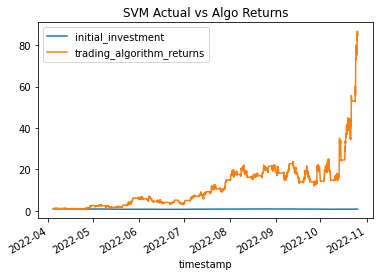

In [56]:
 # Calculated and plotted the cumulative returns for the `initial_investment` and the `trading_algorithm_returns` for the SVM Model
(1 + svm_predictions_df[["initial_investment", "trading_algorithm_returns"]]).cumprod().plot(title='SVM Actual vs Algo Returns')
plt.savefig(f'{ticker}_svm_vs_act_returns', facecolor='white', edgecolor='white', transparent='false', bbox_inches='tight')

In [57]:
 # Calculated and plotted the cumulative returns for the `initial_investment` and the `trading_algorithm_returns` for the SVM Model
(1 + svm_predictions_df[["initial_investment", "trading_algorithm_returns"]]).cumprod()


,initial_investment,trading_algorithm_returns
timestamp,,
2022-04-04 09:50:00+00:00,0.999828,0.998406
2022-04-04 09:55:00+00:00,1.000458,0.998912
2022-04-04 10:00:00+00:00,1.000801,0.999393
2022-04-04 10:05:00+00:00,1.000172,0.997911
2022-04-04 10:10:00+00:00,1.000858,0.998445
...,...,...
2022-10-25 22:20:00+00:00,0.863647,85.749502
2022-10-25 22:25:00+00:00,0.863475,85.446033
2022-10-25 22:30:00+00:00,0.862903,85.193600


### Stochastic Gradient Descent (SGD) Model

In [58]:
#Create the classifier model
SGD_model = SGDClassifier(random_state=1)
# Fit the model to the data using undersampled_continuous_X_train_scaled and undersampled_continuous_y_train
SGD_model.fit(undersampled_continuous_X_train_scaled, undersampled_continuous_y_train)

# Use the trained model to predict the trading signals for the training data
SGD_training_predictions = SGD_model.predict(undersampled_continuous_X_train_scaled)

# Display the sample predictions
SGD_training_predictions[:5]

array([-1,  1, -1,  1,  1])

In [59]:
# Evaluate the model using a classification report
SGD_training_report = classification_report(undersampled_continuous_y_train, SGD_training_predictions)
print(SGD_training_report)

              precision    recall  f1-score   support

          -1       0.52      0.62      0.56      2960
           1       0.53      0.43      0.48      2960

    accuracy                           0.52      5920
   macro avg       0.53      0.52      0.52      5920
weighted avg       0.53      0.52      0.52      5920



In [60]:
# Use the trained model to predict the trading signals for the testing data.
SGD_testing_signal_predictions = SGD_model.predict(continuous_X_test_scaled)

In [61]:
# Evaluate the model's ability to predict the trading signal for the testing data
SGD_testing_report = classification_report(continuous_y_test, SGD_testing_signal_predictions)
print(SGD_testing_report)

              precision    recall  f1-score   support

          -1       0.77      0.16      0.27     19867
           1       0.28      0.87      0.42      7315

    accuracy                           0.35     27182
   macro avg       0.52      0.52      0.34     27182
weighted avg       0.64      0.35      0.31     27182



In [62]:
# Create a predictions DataFrame for sgd
sgd_predictions_df = pd.DataFrame(index=continuous_X_test.index)

sgd_predictions_df["predicted_signal"] = SGD_testing_signal_predictions

sgd_predictions_df["initial_investment"] = signals_df["close"].pct_change()
sgd_predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]

sgd_predictions_df["trading_algorithm_returns"] = (
    sgd_predictions_df["algo_returns"] * sgd_predictions_df["predicted_signal"]
)

sgd_predictions_df = sgd_predictions_df.drop(columns=["algo_returns"])

# Review the DataFrame
sgd_predictions_df

,predicted_signal,initial_investment,trading_algorithm_returns
timestamp,,,
2022-04-04 09:50:00+00:00,-1,-0.000172,-0.001594
2022-04-04 09:55:00+00:00,-1,0.000629,0.000506
2022-04-04 10:00:00+00:00,-1,0.000343,0.000482
2022-04-04 10:05:00+00:00,-1,-0.000629,-0.001483
2022-04-04 10:10:00+00:00,-1,0.000686,0.000535
...,...,...,...
2022-10-25 22:20:00+00:00,1,-0.001125,-0.003434
2022-10-25 22:25:00+00:00,1,-0.000199,-0.003539
2022-10-25 22:30:00+00:00,1,-0.000662,-0.002954


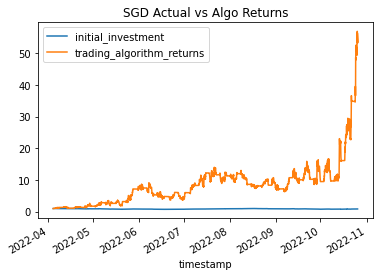

In [63]:
 # Calculated and plotted the cumulative returns for the `actual_returns` and the `trading_algorithm_returns` for the sgd Model
(1 + sgd_predictions_df[["initial_investment", "trading_algorithm_returns"]]).cumprod().plot(title='SGD Actual vs Algo Returns')


plt.savefig(f'{ticker}_sgd_vs_act_returns', facecolor='white', edgecolor='white', transparent='false', bbox_inches='tight')

In [64]:
 # Calculated and plotted the cumulative returns for the `actual_returns` and the `trading_algorithm_returns` for the SVM Model
(1 + sgd_predictions_df[["initial_investment", "trading_algorithm_returns"]]).cumprod()


,initial_investment,trading_algorithm_returns
timestamp,,
2022-04-04 09:50:00+00:00,0.999828,0.998406
2022-04-04 09:55:00+00:00,1.000458,0.998912
2022-04-04 10:00:00+00:00,1.000801,0.999393
2022-04-04 10:05:00+00:00,1.000172,0.997911
2022-04-04 10:10:00+00:00,1.000858,0.998445
...,...,...
2022-10-25 22:20:00+00:00,0.863647,53.977237
2022-10-25 22:25:00+00:00,0.863475,53.786210
2022-10-25 22:30:00+00:00,0.862903,53.627310


###  Decision Tree Model

In [65]:
# Create the decision tree classifier instance
rf_model = tree.DecisionTreeClassifier(random_state=1)

In [66]:
# Fit the model
rf_model = rf_model.fit(undersampled_discrete_X_train, undersampled_discrete_y_train)

In [67]:
# Making predictions using the testing data
predictions = rf_model.predict(discrete_X_test)

# Use the trained model to predict the trading signals for the training data
rf_training_signal_predictions = rf_model.predict(undersampled_discrete_X_train)

In [68]:
# Evaluate the model using a classification report
rf_training_report = classification_report(undersampled_discrete_y_train, rf_training_signal_predictions)
print(rf_training_report)

              precision    recall  f1-score   support

          -1       0.53      0.34      0.41      2960
           1       0.51      0.70      0.59      2960

    accuracy                           0.52      5920
   macro avg       0.52      0.52      0.50      5920
weighted avg       0.52      0.52      0.50      5920



In [69]:
# Use the trained model to predict the trading signals for the testing data.
rf_testing_signal_predictions = rf_model.predict(discrete_X_test)

In [70]:
# Evaluate the model's ability to predict the trading signal for the testing data
rf_testing_report = classification_report(discrete_y_test, rf_testing_signal_predictions)
print(rf_testing_report)

              precision    recall  f1-score   support

          -1       0.75      0.33      0.46     19867
           1       0.28      0.69      0.40      7315

    accuracy                           0.43     27182
   macro avg       0.51      0.51      0.43     27182
weighted avg       0.62      0.43      0.44     27182



In [71]:
# Create a predictions DataFrame for rf
rf_predictions_df = pd.DataFrame(index=continuous_X_test.index)

rf_predictions_df["predicted_signal"] = rf_testing_signal_predictions

rf_predictions_df["initial_investment"] = signals_df["close"].pct_change()

rf_predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]

rf_predictions_df["trading_algorithm_returns"] = (
    rf_predictions_df["algo_returns"] * rf_predictions_df["predicted_signal"]
)

rf_predictions_df = rf_predictions_df.drop(columns=["algo_returns"])

# Review the DataFrame
rf_predictions_df.head()

,predicted_signal,initial_investment,trading_algorithm_returns
timestamp,,,
2022-04-04 09:50:00+00:00,-1,-0.000172,-0.001594
2022-04-04 09:55:00+00:00,-1,0.000629,0.000506
2022-04-04 10:00:00+00:00,-1,0.000343,0.000482
2022-04-04 10:05:00+00:00,1,-0.000629,0.001483
2022-04-04 10:10:00+00:00,-1,0.000686,0.000535


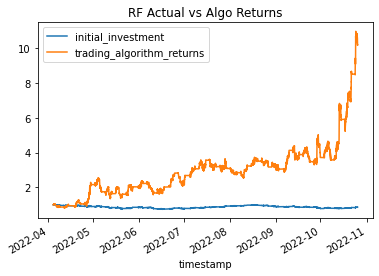

In [72]:
 # Calculated and plotted the cumulative returns for the `actual_returns` and the `trading_algorithm_returns` for the rf Model
(1 + rf_predictions_df[["initial_investment", "trading_algorithm_returns"]]).cumprod().plot(title='RF Actual vs Algo Returns')
plt.savefig(f'{ticker}_rf_vs_act_returns', facecolor='white', edgecolor='white', transparent='false', bbox_inches='tight')

In [73]:
# markdown here about exporting the graph

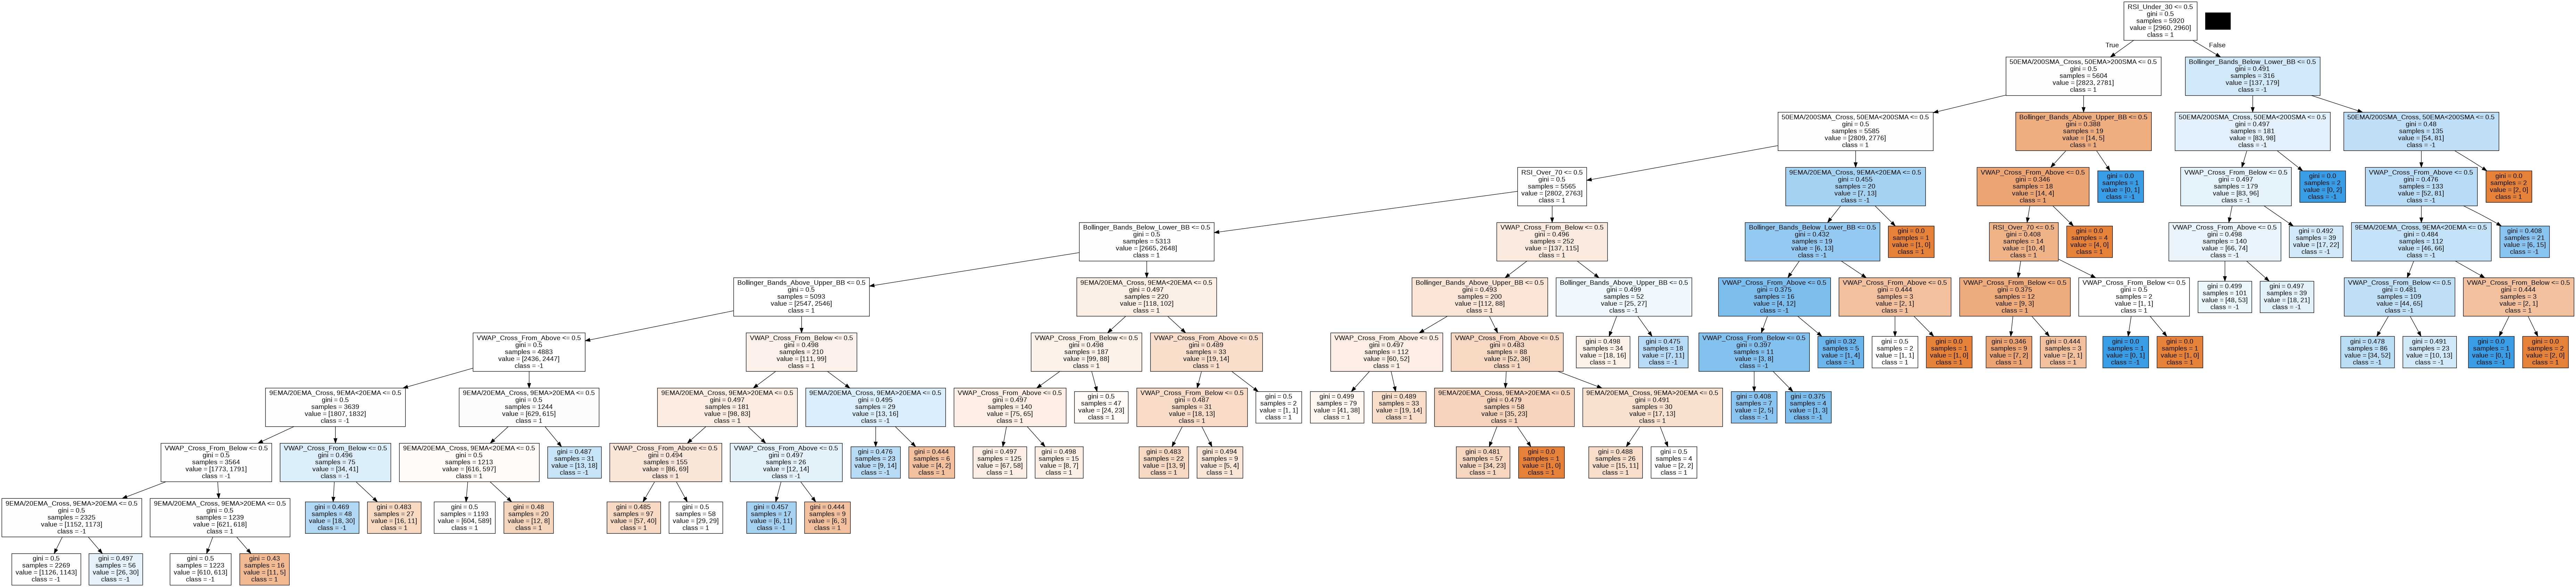

In [74]:
# Create DOT data
dot_data = tree.export_graphviz(
    rf_model, out_file=None, feature_names=discrete_X.columns, class_names=["1", "-1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())



In [52]:
# When saving the image, Path() is not used because graph.write_<file_type>() must take a string object
# Saving the tree as PDF
file_path = "transactions_tree.pdf"
graph.write_pdf(file_path)

# Saving the tree as PNG
file_path = "transactions_tree.png"
graph.write_png(file_path)


True

In [53]:
# rank the most important features
importances = rf_model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, discrete_X.columns), reverse=True)
importances_sorted[:10]

[(0.1897895916003052, 'VWAP_Cross_From_Below'),
 (0.12834638052934164, 'VWAP_Cross_From_Above'),
 (0.11797823324442627, '50EMA/200SMA_Cross, 50EMA<200SMA'),
 (0.11540146180676622, '9EMA/20EMA_Cross, 9EMA>20EMA'),
 (0.10699038973640979, 'RSI_Under_30'),
 (0.08223920659857827, 'Bollinger_Bands_Above_Upper_BB'),
 (0.07517325154869779, '50EMA/200SMA_Cross, 50EMA>200SMA'),
 (0.07422682937143359, '9EMA/20EMA_Cross, 9EMA<20EMA'),
 (0.07120482653342926, 'Bollinger_Bands_Below_Lower_BB'),
 (0.03864982903061194, 'RSI_Over_70')]

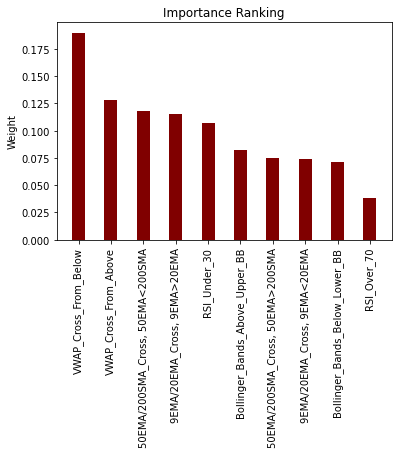

In [54]:
#Create Two Lists to make a bar graph outlining the weight of each discrete feature
i = 0
x = []
y = []

for k in importances_sorted:
    x.append(str(importances_sorted[i][1]))
    y.append(importances_sorted[i][0])
    i += 1

#Create and save the bar graph
plt.bar(x, y, color ='maroon', width = 0.4)
plt.title('Importance Ranking')
plt.ylabel('Weight')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.savefig(f'{ticker}_importance_ranking', facecolor='white', edgecolor='white', transparent='false', bbox_inches='tight')